# Flight Data Recorder
<img src="media/fdr.jpg" width="400px" height="auto">

# Sensor IMU Data Analysis
This notebook contains the following data visualization tools
- 3D position scatter plot (interactive)
- Pitch/roll/yaw histograms
- Pitch vs velocity
- Stability vs velocity

## Setting up interactive plots
Run the following terminal commands (once) to install IPython ([source](https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab)). It might take a few minutes. If the plots don't load, stop and restart the jupyter server.

In [ ]:
# run this only once
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter lab build

## Parsing the CSV File


In [13]:
import pandas as pd

# Modify this section to change files and data format

sensor_files = ['sensor_1.TXT', 'sensor_2.TXT', 'sensor_3.TXT','sensor_4.TXT','sensor_5.TXT','sensor_6.TXT',]
fdr_files = ['fdr_1.TXT', 'fdr_2.TXT', 'fdr_3.TXT', 'fdr_4.TXT', 'fdr_5.TXT', 'fdr_6.TXT']
# Use relative path
path = 'inputData/'

# Count, System Calibration level (0-3), Linear Acceleration XYZ (m/s^2), Gyro XYZ (radians/sec), Quaternion WXYZ
sensor_header = [
    'count', 
    'sr_sys', 
    'sr_x_accel', 
    'sr_y_accel', 
    'sr_z_accel', 
    'sr_x_rps', 
    'sr_y_rps', 
    'sr_z_rps', 
    'sr_qw', 
    'sr_qx', 
    'sr_qy', 
    'sr_qz']

# GPS data comes in NMEA GPGGA sentences
# important ones are UTC time, latitude, longitude, num sats, elevation
fdr_header = [
    'count', 
    'fr_sys', 
    'fr_x_accel', 
    'fr_y_accel', 
    'fr_z_accel', 
    'fr_x_rps', 
    'fr_y_rps', 
    'fr_z_rps', 
    'fr_qw', 
    'fr_qx', 
    'fr_qy', 
    'fr_qz',
    'gps', 
    'UTC', 
    'lat', 
    'NS', 
    'long', 
    'EW', 
    'fix', 
    'sats', 
    'HDOP', 
    'elev', 
    'units1', 
    'geoid', 
    'units2', 
    'age', 
    'checksum'
]

In [14]:
# store flight data in a list of dataframes
df_list = []

# put the csv into dataframes with a header
for i in range(len(sensor_files)):
    # add sensor file
    filepath = path + sensor_files[i]
    df_sr = pd.read_csv(filepath, sep=",", header=None)
    # add header
    df_sr.columns = sensor_header
    # add fdr file
    filepath = path + fdr_files[i]
    df_fr = pd.read_csv(filepath, sep=",", header=None)
    # add header
    df_fr.columns = fdr_header
    # merge dataframes sensor + fdr
    df = pd.merge(df_sr, df_fr, how='left',on='count')
    df_list.append(df)

In [15]:
# remove bad rows
def remove_rows(df):
    #drop rows if either system calibration level is 0
    #rows = df[(df['sr_sys'] == 0) | (df['fr_sys'] == 0)].index
    rows = df[df['sr_sys'] == 0].index
    df.drop(rows, inplace=True)

for i in range(len(df_list)):
    remove_rows(df_list[i])

# remove unused columns
def remove_cols(df):
    df.drop(['gps','UTC','NS', 'EW','HDOP','units1', 'geoid', 'units2', 'age', 'checksum'], axis='columns', inplace=True)
    
for i in range(len(df_list)):
    remove_cols(df_list[i])

# remove all rows with NaN values
for i in range(len(df_list)):
    df_list[i].dropna(inplace=True)

# decimal latitude conversion
def dd_lat(x):
    degrees = int(x) // 100
    minutes = x - 100*degrees
    return degrees + minutes/60

# decimal longitude conversion
def dd_lon(x):
    return -dd_lat(x)

# apply latitude and longitude conversions to all rows
for i in range(len(df_list)):
    df_list[i]['lat'] = df_list[i]['lat'].apply(dd_lat)
    df_list[i]['long'] = df_list[i]['long'].apply(dd_lon)
    

# add prev_lat, prev_long, speed columns

# add a previous count, lat, and long column
for i in range(len(df_list)):
    df_list[i]['prev_lat'] = df_list[i]['lat'].shift(1)
    df_list[i]['prev_long'] = df_list[i]['long'].shift(1)
    df_list[i]['prev_count'] = df_list[i]['count'].shift(1)
    # deletes first row
    df_list[i].dropna(inplace=True)



# Get bearing between coordinate points

# https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
# https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/
import math

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = math.atan2(x,y)
    #brng = np.rad2deg(brng)
    return brng

def bearing_wrapper(row):
    lat1 = row['prev_lat']
    long1 = row['prev_long']
    lat2 = row['lat']
    long2 = row['long']
    return get_bearing(lat1, long1, lat2, long2)

for i in range(len(df_list)):
    df_list[i]['bearing'] = df_list[i].apply(lambda row: bearing_wrapper(row), axis=1)

# https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
from math import pi,sqrt,sin,cos,atan2

# calculate the distance between two points on a sphere
def haversine(row):
    lat1 = row['prev_lat']
    long1 = row['prev_long']
    lat2 = row['lat']
    long2 = row['long']
                                                                
    degree_to_rad = float(pi / 180.0)

    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad

    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    mi = 3956 * c
    return mi

def speed(row):
    millis = row['count'] - row['prev_count']
    hours = millis / 36000
    return row['delta'] / hours

for i in range(len(df_list)):
    # delta distance
    df_list[i]['delta'] = df_list[i].apply(lambda row: haversine(row), axis=1)
    # add mph column
    df_list[i]['mph'] = df_list[i].apply(lambda row: speed(row), axis=1)
    # remove temp columns
    df_list[i].drop(columns=['delta', 'prev_lat', 'prev_long', 'prev_count'], inplace=True)

# speed (line) plots vs time
#for i in range(len(df_list)): 
#    df_list[i].plot.line(x='count', y='mph')

In [4]:
# only need to run this once
# https://medium.com/@thabangline/how-to-use-conda-and-pip-to-install-packages-within-jupyter-notebook-d0f2ed23b059
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} cartopy

failed

CondaError: KeyboardInterrupt



In [16]:
# https://scitools.org.uk/cartopy/docs/latest/gallery/tube_stations.html#sphx-glr-gallery-tube-stations-py
%matplotlib inline
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM # uses tiles from Open Street Map

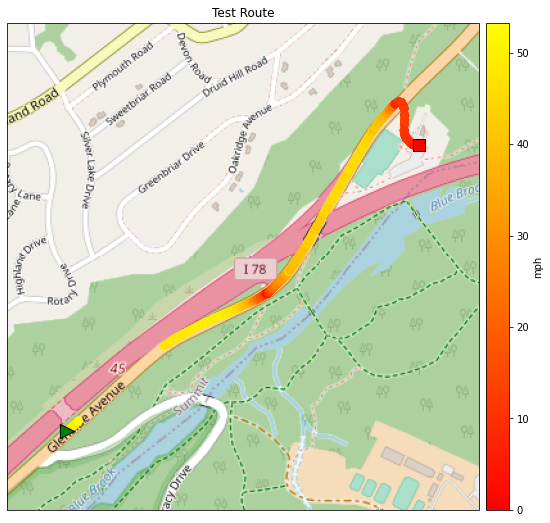

In [20]:
i = 0

padding_lat = 0.002
padding_lon = 0.002
# set window coordinates (bottom left to top right)
lat1 = df_list[i]['lat'].min() - padding_lat
lat2 = df_list[i]['lat'].max() + padding_lat
lon1 = df_list[i]['long'].min() - padding_lon
lon2 = df_list[i]['long'].max() + padding_lon

imagery = OSM()

fig = plt.figure(figsize=(9, 13))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())

# Add the imagery to the map.
# Modify SCALE here (also +/- resolution)
ax.add_image(imagery, 15)

# plot all gps coords
scat = ax.scatter(df_list[i]['long'], df_list[i]['lat'],c=df_list[i]['mph'], cmap='autumn',s=60,alpha=1,transform=ccrs.PlateCarree())

# plot start and stop coords with special symbols
ax.scatter(df_list[i]['long'].head(1), df_list[i]['lat'].head(1),marker=">",color='green',edgecolors='black',linewidths=1,s=200,alpha=1,transform=ccrs.PlateCarree())
ax.scatter(df_list[i]['long'].tail(1), df_list[i]['lat'].tail(1),marker="s",color='red',edgecolors='black',linewidths=1,s=160,alpha=1,transform=ccrs.PlateCarree())

# add a colorbar
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(scat,cax=ax_cb,label='mph')


ax.set_title('Test Route')
plt.show()

In [27]:
%matplotlib widget
fig = plt.figure() 
ax = plt.axes(projection ='3d') 
ax.axes.set_xlim3d(left=df_list[0]['long'].min(), right=df_list[0]['long'].max()) 
ax.axes.set_ylim3d(bottom=df_list[0]['lat'].min(), top=df_list[0]['lat'].max()) 
ax.axes.set_zlim3d(bottom=0, top=df_list[0]['elev'].max()) 
ax.axes.set_xlabel('Longitude')
ax.axes.set_ylabel('Latitude')
ax.axes.set_zlabel('Elevation')

ax.scatter(df_list[0]['long'], df_list[0]['lat'], df_list[0]['elev'],s=2,c=df_list[0]['mph'],cmap='autumn',depthshade=True) 

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
df_list[0].plot.scatter(x='count', y='sr_x_accel', c='mph', cmap='autumn')
df_list[0].plot.scatter(x='count', y='sr_y_accel', c='mph', cmap='autumn')
df_list[0].plot.scatter(x='count', y='sr_z_accel', c='mph', cmap='autumn')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='count', ylabel='sr_z_accel'>

In [11]:
# only need to run this once

# https://medium.com/@thabangline/how-to-use-conda-and-pip-to-install-packages-within-jupyter-notebook-d0f2ed23b059
# pytransform3d not in any conda channels, use pip instead, but it might not be tracked in conda
import sys
!{sys.executable} -m pip install pytransform3d
# pytransform3d-1.5

In [26]:
%matplotlib widget
from pytransform3d.plot_utils import plot_vector
from pytransform3d.rotations import quaternion_integrate, matrix_from_quaternion, plot_basis

fig = plt.figure(figsize=(10,10)) 
ax3 = plt.axes(projection ='3d') 
ax3.axes.set_xlim3d(left=df_list[0]['long'].min(), right=df_list[0]['long'].max()) 
ax3.axes.set_ylim3d(bottom=df_list[0]['lat'].min(), top=df_list[0]['lat'].max()) 
ax3.axes.set_zlim3d(bottom=0, top=df_list[0]['elev'].max()) 
ax3.axes.set_xlabel('Longitude')
ax3.axes.set_ylabel('Latitude')
ax3.axes.set_zlabel('Elevation')


# select every nth row
n=20
Q = df_list[0][['fr_qw','fr_qx','fr_qy','fr_qz']][::n].to_numpy()

ax = None # I think i need this line to reset ax from previous plots, so it doesn't interfere with this one
for t in range(len(Q)):
    R = matrix_from_quaternion(Q[t])
    p = np.array([df_list[0].iloc[t*n]['long'],df_list[0].iloc[t*n]['lat'],df_list[0].iloc[t*n]['elev']])
    #plot_vector(ax=ax, direction=b, color="g")
    ax3 = plot_basis(ax=ax3, s=0.0015, R=R, p=p)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Quaternions vs Euler Angles

The absolute position of an object in 3D space can be represented using either Euler angles or quaternions. Euler angles consist of a set of 3 angles about the X, Y, and Z axes (yaw, pitch, and roll). However, the order in which the 3 rotations are done is important. Changing the sequence of operations can affect the final orientation of the object even if the operations are the same ([here](https://www.sjbaker.org/steve/omniv/eulers_are_evil.html) is an example). Quaternions on the other hand describe a one-to-one orientation, so only one quaternion can describe a specific orientation and visa versa. Additionally, they don't suffer from roundoff error issues.

In the case of BNO055 IMU data, Euler angles should not be trusted unless pitch and roll stay under 45 degrees (which they do not). Thus, data  from the IMU will be recorded using quaternions. 

In [23]:
# https://www.meccanismocomplesso.org/en/hamiltons-quaternions-and-3d-rotation-with-python/

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def euler_to_quaternion(phi, theta, psi):
 
        qw = m.cos(phi/2) * m.cos(theta/2) * m.cos(psi/2) + m.sin(phi/2) * m.sin(theta/2) * m.sin(psi/2)
        qx = m.sin(phi/2) * m.cos(theta/2) * m.cos(psi/2) - m.cos(phi/2) * m.sin(theta/2) * m.sin(psi/2)
        qy = m.cos(phi/2) * m.sin(theta/2) * m.cos(psi/2) + m.sin(phi/2) * m.cos(theta/2) * m.sin(psi/2)
        qz = m.cos(phi/2) * m.cos(theta/2) * m.sin(psi/2) - m.sin(phi/2) * m.sin(theta/2) * m.cos(psi/2)
 
        return [qw, qx, qy, qz]

def quaternion_to_euler(w, x, y, z):
 
        t0 = 2 * (w * x + y * z)
        t1 = 1 - 2 * (x * x + y * y)
        X = m.atan2(t0, t1)
 
        t2 = 2 * (w * y - z * x)
        t2 = 1 if t2 > 1 else t2
        t2 = -1 if t2 < -1 else t2
        Y = m.asin(t2)
         
        t3 = 2 * (w * z + x * y)
        t4 = 1 - 2 * (y * y + z * z)
        Z = m.atan2(t3, t4)
 
        return X, Y, Z


In [24]:
import math as m
# input vector
v1 = (1,0,0)
phi = 0 # controls roll (this shouldn't affect a point)
theta = 0 # controls pitch (0 = horizontal, pi/2 = vertical)
psi = -m.pi/2 # controlls yaw (0 = center, pi/2 = 90 deg CW)
# quaternion: roll, pitch, yaw
q = euler_to_quaternion(phi, theta, psi)
print(q)

# output vector
v2 = qv_mult(q,v1)
v2

[0.7071067811865476, 0.0, 0.0, -0.7071067811865475]


(2.220446049250313e-16, -1.0, 0.0)

In [25]:
# Enable interactive plots
%matplotlib widget

# import packages
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib.pyplot as plt
import numpy as np
import math

# change parameters here
radius = 1

# define constant sqrt 2 over 2
srtot = math.sqrt(2)/2

fig = plt.figure(figsize=(5,5))
# add subplot with nrows, ncols, index
ax = fig.add_subplot(111, projection='3d')
# define axis scale & labels
ax.axes.set_xlim3d(left=radius, right=0) 
ax.axes.set_ylim3d(bottom=srtot*radius, top=-srtot*radius) # flip y axis for sensor
ax.axes.set_zlim3d(bottom=-radius, top=0) 
ax.axes.set_xlabel('x')
ax.axes.set_ylabel('y')
ax.axes.set_zlabel('z')

# Set equal unit aspect ratio
ax.set_box_aspect((radius, math.sqrt(2)*radius, radius))

# Make surface data
u = np.linspace(0, 0.5*np.pi, 15)
v = np.linspace(0.25*np.pi, 0.75*np.pi, 15)
x = radius * np.outer(np.cos(u), np.sin(v))
z = -radius * np.outer(np.sin(u), np.sin(v))
y = radius * np.outer(np.ones(np.size(u)), np.cos(v))




# set dotted line colors
lc="grey"
# horizontal 3 arrows
# x1,y1,z1,x2,y2,z2
'''
ax.quiver(0, 0, 0, radius, 0, 0, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, srtot*radius, srtot*radius, 0, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, srtot*radius, -srtot*radius, 0, color=lc,ls='dashed',arrow_length_ratio=0)

# vertical 3 arrows
ax.quiver(0, 0, 0, 0, 0, -radius, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, srtot*radius, -srtot*radius, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, -srtot*radius, -srtot*radius, color=lc,ls='dashed',arrow_length_ratio=0)
'''
# sensor
#g = Arrow3D([0, srtot*radius], [0, 0], [0, -srtot*radius], mutation_scale=20, lw=1, arrowstyle="simple", color="k")
ax.quiver(0, 0, 0, srtot*radius, 0, -srtot*radius, color='black',ls='solid',lw = 2,arrow_length_ratio=0.1)



def adj_heading(row, v):
    sw = row['sr_qw']
    sx = row['sr_qx']
    sy = row['sr_qy']
    sz = row['sr_qz']
    #transf = (1,0,0) # this is the start vertex, points North
    # args: roll, pitch, yaw: 90 deg CCW for sensor reorientation
    q = euler_to_quaternion(0, 0, m.pi/2)
    q1 = (sw,sx,sy,sz) # <---- This raw sensor input
    q2 = q_mult(q,q1) # <---- rotate 90 deg CCW
    # now take GPS bearing and get it in quaternion
    q3 = euler_to_quaternion(0, 0, row['bearing']) # maybe negative bearing??
    q4 = q_mult(q3,q2)
    v = qv_mult(q4, v)
    return v


# select sample frequency
n=1

def qv_mult_wrapper(row,v):
    w = row['sr_qw']
    x = row['sr_qx']
    y = row['sr_qy']
    z = row['sr_qz']
    q = [w,x,y,z]
    t = qv_mult(q,v)
    return t[0], t[1], t[2]

# plot transformed vectors


for i in range(len(df_list)):
    # start vector
    v1 = (1,0,0)
    
    # raw data
    #df_list[i]['v2'] = df_list[i][::n].apply(lambda row: qv_mult_wrapper(row,v1), axis=1)
    
    # account for bearing and sensor orientation
    df_list[i]['v2'] = df_list[i][::n].apply(lambda row: adj_heading(row,v1), axis=1)


# select plot
i = 2
'''
# test inversion
testv = (1,0,0)
ax.quiver(0, 0, 0, testv[0], testv[1], testv[2], color='g',linestyle='dashed',arrow_length_ratio=0.1)
inv = (-0.0706,0.9187,-0.2443,-0.3021)
testv = qv_mult(inv,testv)
ax.quiver(0, 0, 0, testv[0], testv[1], testv[2], color='g',linestyle='dashed',arrow_length_ratio=0.1)
'''


    
vx = 0
vy = 0
vz = 0
vx = df_list[i]['v2'][::n].str[0].to_numpy()
vy = df_list[i]['v2'][::n].str[1].to_numpy()
vz = df_list[i]['v2'][::n].str[2].to_numpy()
#zeros = np.zeros(len(vx))



# perhaps use point instead of vector
ax.scatter(vx,vy,vz,c=df_list[i]['mph'][::n], cmap='autumn',depthshade=True)

# Graph using arrows
# assign colors based on mph (https://github.com/matplotlib/matplotlib/issues/3382) (https://stackoverflow.com/questions/28420504/adding-colors-to-a-3d-quiver-plot-in-matplotlib)
C = df_list[i]['mph'][::n].to_numpy()
C = C/df_list[i]['mph'][::n].max()
cmap = plt.get_cmap()
#ax.quiver(zeros,zeros,zeros,vx,vy,vz,color=cmap(C), cmap='autumn',linestyle='dashed',arrow_length_ratio=0.1) 



# perhaps plot vectors as positions on map
#p = np.array([df_list[0].iloc[t*n]['long'],df_list[0].iloc[t*n]['lat'],df_list[0].iloc[t*n]['elev']])



# Plot the surface
ax.plot_surface(x, y, z, color='grey',alpha=0.2)
ax.plot_wireframe(x, y, z, color='grey',alpha=0.3, lw = 1)
# Plot a dot
ax.scatter([0], [0], [0], color="b", s=25)
# fig.savefig("test.png")
  
plt.grid(b=None)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

- Sensor is always measuring +90 deg yaw, so rotate -90 deg: psi = -m.pi/2
- Quaternions describe a sequence of rotations as multiplications (instead of additions in Euler angles)